In [1]:
import pandas as pd
import skimage.io
import skimage.color
import skimage.metrics
import skimage.util
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import os
import math

%matplotlib inline

In [ ]:
daily_data_volume_gb = {
    "Modis": 17.51,
    "GeoEye-1": 921.05,
}

print("Dane wejściowe (dzienny wolumen danych w GB):")
for sensor, volume in daily_data_volume_gb.items():
    print(f"- {sensor}: {volume} GB")

SyntaxError: invalid syntax (1545091268.py, line 4)

In [3]:
def simulate_volume_compression(sensor_data_gb):
    """Symuluje wolumen danych po kompresji."""
    
    results = []
    
    for sensor_name, original_volume_gb in sensor_data_gb.items():
        compressed_2_1 = original_volume_gb / 2
        compressed_5_1 = original_volume_gb / 5
        compressed_10_1 = original_volume_gb / 10
        compressed_20_1 = original_volume_gb / 20
        
        results.append({
            "Nazwa sensora": sensor_name,
            "Dane przed kompresją (GB)": original_volume_gb,
            "Dane po kompresji 2:1 (GB)": compressed_2_1,
            "Dane po kompresji 5:1 (GB)": compressed_5_1,
            "Dane po kompresji 10:1 (GB)": compressed_10_1,
            "Dane po kompresji 20:1 (GB)": compressed_20_1
        })
        
    df_results = pd.DataFrame(results)
    
    return df_results

In [4]:
compression_results_df = simulate_volume_compression(daily_data_volume_gb)

print("\nTabela wpływu kompresji na dzienny wolumen danych:")
print(compression_results_df)


Tabela wpływu kompresji na dzienny wolumen danych:
  Nazwa sensora  Dane przed kompresją (GB)  Dane po kompresji 2:1 (GB)  \
0         Modis                      200.0                       100.0   
1      GeoEye-1                      930.0                       465.0   

   Dane po kompresji 5:1 (GB)  Dane po kompresji 10:1 (GB)  \
0                        40.0                         20.0   
1                       186.0                         93.0   

   Dane po kompresji 20:1 (GB)  
0                         10.0  
1                         46.5  


In [5]:
data_folder = "data"
image_filename = "65.png"

image_path = os.path.join(data_folder, image_filename)

original_image = None

Wczytano obraz: data\65.png
Typ danych wczytanego obrazu: uint8
Wymiary wczytanego obrazu: (860, 1804, 4)
Obraz RGBA, konwertuję do RGB, a następnie do skali szarości.


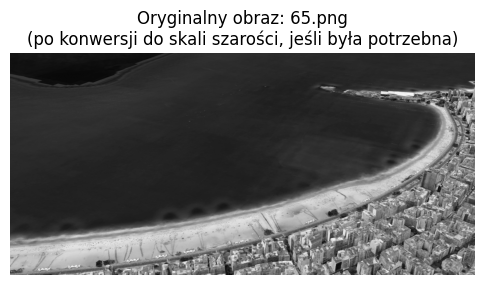

Typ danych finalnego obrazu (original_image): uint8
Wymiary finalnego obrazu: (860, 1804)
Zakres wartości pikseli: 5 - 254


In [6]:
try:
    loaded_image = skimage.io.imread(image_path)

    if loaded_image is None:
        raise IOError(f"Nie udało się wczytać obrazu z: {image_path}")

    print(f"Wczytano obraz: {image_path}")
    print(f"Typ danych wczytanego obrazu: {loaded_image.dtype}")
    print(f"Wymiary wczytanego obrazu: {loaded_image.shape}")

    if loaded_image.ndim == 3:
        if loaded_image.shape[2] == 4: # RGBA
            print("Obraz RGBA, konwertuję do RGB, a następnie do skali szarości.")
            # Konwersja RGBA do RGB (ignorowanie kanału alfa)
            loaded_image_rgb = skimage.color.rgba2rgb(loaded_image)
             # Konwersja RGB do skali szarości (wynik jako float64 w zakresie [0,1])
            original_image_gray = skimage.color.rgb2gray(loaded_image_rgb)
        elif loaded_image.shape[2] == 3: # RGB
            print("Obraz RGB, konwertuję do skali szarości.")
            # Konwersja RGB do skali szarości (wynik jako float64 w zakresie [0,1])
            original_image_gray = skimage.color.rgb2gray(loaded_image)
        else:
            print(f"Obraz ma {loaded_image.shape[2]} kanałów. Używam pierwszego kanału jako skali szarości.")
            original_image_gray = loaded_image[..., 0] # Weź pierwszy kanał
    elif loaded_image.ndim == 2:
        print("Obraz jest już w skali szarości.")
        original_image_gray = loaded_image
    else:
        raise ValueError(f"Nieobsługiwana liczba wymiarów obrazu: {loaded_image.ndim}. Oczekiwano 2 (skala szarości) lub 3 (kolor).")

  
    original_image = skimage.util.img_as_ubyte(original_image_gray)

    plt.figure(figsize=(6, 6))
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Oryginalny obraz: {image_filename}\n(po konwersji do skali szarości, jeśli była potrzebna)")
    plt.axis('off')
    plt.show()

    print(f"Typ danych finalnego obrazu (original_image): {original_image.dtype}")
    print(f"Wymiary finalnego obrazu: {original_image.shape}")
    print(f"Zakres wartości pikseli: {original_image.min()} - {original_image.max()}")

except FileNotFoundError:
    print(f"BŁĄD: Nie znaleziono pliku obrazu: {image_path}")
    print(f"Upewnij się, że folder '{data_folder}' istnieje w tym samym miejscu co notatnik,")
    print(f"oraz że plik '{image_filename}' znajduje się wewnątrz folderu '{data_folder}'.")
    print("Popraw zmienną 'image_filename' i/lub umieść plik w odpowiednim miejscu.")
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd podczas wczytywania lub przetwarzania obrazu: {e}")
    print("Sprawdź, czy plik obrazu nie jest uszkodzony i czy jest to obsługiwany format (np. PNG, JPG, TIF).")

In [7]:
def compress_jpeg_in_memory(image_array, quality_level):
    """Kompresuje obraz do formatu JPEG w pamięci i zwraca skompresowany obraz oraz jego rozmiar."""
    
    pil_image = Image.fromarray(image_array)
    img_buffer = io.BytesIO()
    pil_image.save(img_buffer, format="JPEG", quality=quality_level, optimize=True)
    file_size_bytes = img_buffer.tell()
    
    file_size_kb = file_size_bytes / 1024.0
    img_buffer.seek(0)
    
    decompressed_pil_image = Image.open(img_buffer)
    decompressed_image_array = np.array(decompressed_pil_image)
    
    return decompressed_image_array, file_size_kb

In [10]:
if 'original_image' in globals() and original_image is not None:
    original_image_float = skimage.util.img_as_float(original_image)
    
    # Przebudowujemy compressed_results od zera
    new_compressed_results = [] 
    
    jpeg_quality_levels = [95, 75, 50, 25, 10, 5] # Upewnij się, że to jest zdefiniowane

    print("\nRozpoczynam kompresję, obliczanie PSNR, SSIM i map różnic...")
    for quality in jpeg_quality_levels:
        compressed_img_uint8, size_kb = compress_jpeg_in_memory(original_image, quality)
        compressed_img_float = skimage.util.img_as_float(compressed_img_uint8)
        
        psnr_value = skimage.metrics.peak_signal_noise_ratio(original_image, compressed_img_uint8, data_range=255)
        
        # Ustalenie win_size dla SSIM dynamicznie, aby uniknąć błędów dla małych obrazów
        # win_size musi być nieparzysty i <= min(wymiary obrazu)
        min_dimension = min(original_image_float.shape[:2])
        current_win_size = min(7, min_dimension if min_dimension % 2 != 0 else min_dimension -1)
        if current_win_size < 3 : # SSIM wymaga win_size >= 3
            print(f"Ostrzeżenie: Obraz jest za mały ({original_image_float.shape}) dla SSIM z win_size={current_win_size}. Pomijam SSIM.")
            ssim_value = np.nan # Not a Number
        else:
             ssim_value = skimage.metrics.structural_similarity(
                original_image_float, 
                compressed_img_float, 
                data_range=1.0, # Dla float [0,1]
                win_size=current_win_size,
                channel_axis=None if original_image_float.ndim == 2 else -1 # Dla obrazów skali szarości można pominąć lub dać None
                                                                           # Dla kolorowych (3D) dać oś kanałów, np. -1
            )
            
        diff_map_float = np.abs(original_image_float - compressed_img_float)
        
        new_compressed_results.append({
            "quality": quality,
            "image": compressed_img_uint8, # Zmieniamy klucz z 'image_uint8' na 'image' dla spójności
            "size_kb": size_kb,
            "psnr": psnr_value,
            "ssim": ssim_value,
            "diff_map": diff_map_float
        })
        print(f"JPEG Jakość: {quality}, Rozmiar: {size_kb:.2f} KB, PSNR: {psnr_value:.2f} dB, SSIM: {ssim_value:.3f}")
    
    # Nadpisujemy starą listę compressed_results nową, ulepszoną
    compressed_results = new_compressed_results 

else:
    print("\nNie można kontynuować, oryginalny obraz nie został wczytany.")
    # compressed_results powinno być puste lub nie istnieć


Rozpoczynam kompresję, obliczanie PSNR, SSIM i map różnic...
JPEG Jakość: 95, Rozmiar: 353.95 KB, PSNR: 47.23 dB, SSIM: 0.994
JPEG Jakość: 75, Rozmiar: 134.36 KB, PSNR: 39.17 dB, SSIM: 0.980
JPEG Jakość: 50, Rozmiar: 88.26 KB, PSNR: 36.73 dB, SSIM: 0.968
JPEG Jakość: 25, Rozmiar: 56.04 KB, PSNR: 34.44 dB, SSIM: 0.948
JPEG Jakość: 10, Rozmiar: 28.36 KB, PSNR: 31.03 dB, SSIM: 0.901
JPEG Jakość: 5, Rozmiar: 15.81 KB, PSNR: 27.72 dB, SSIM: 0.836


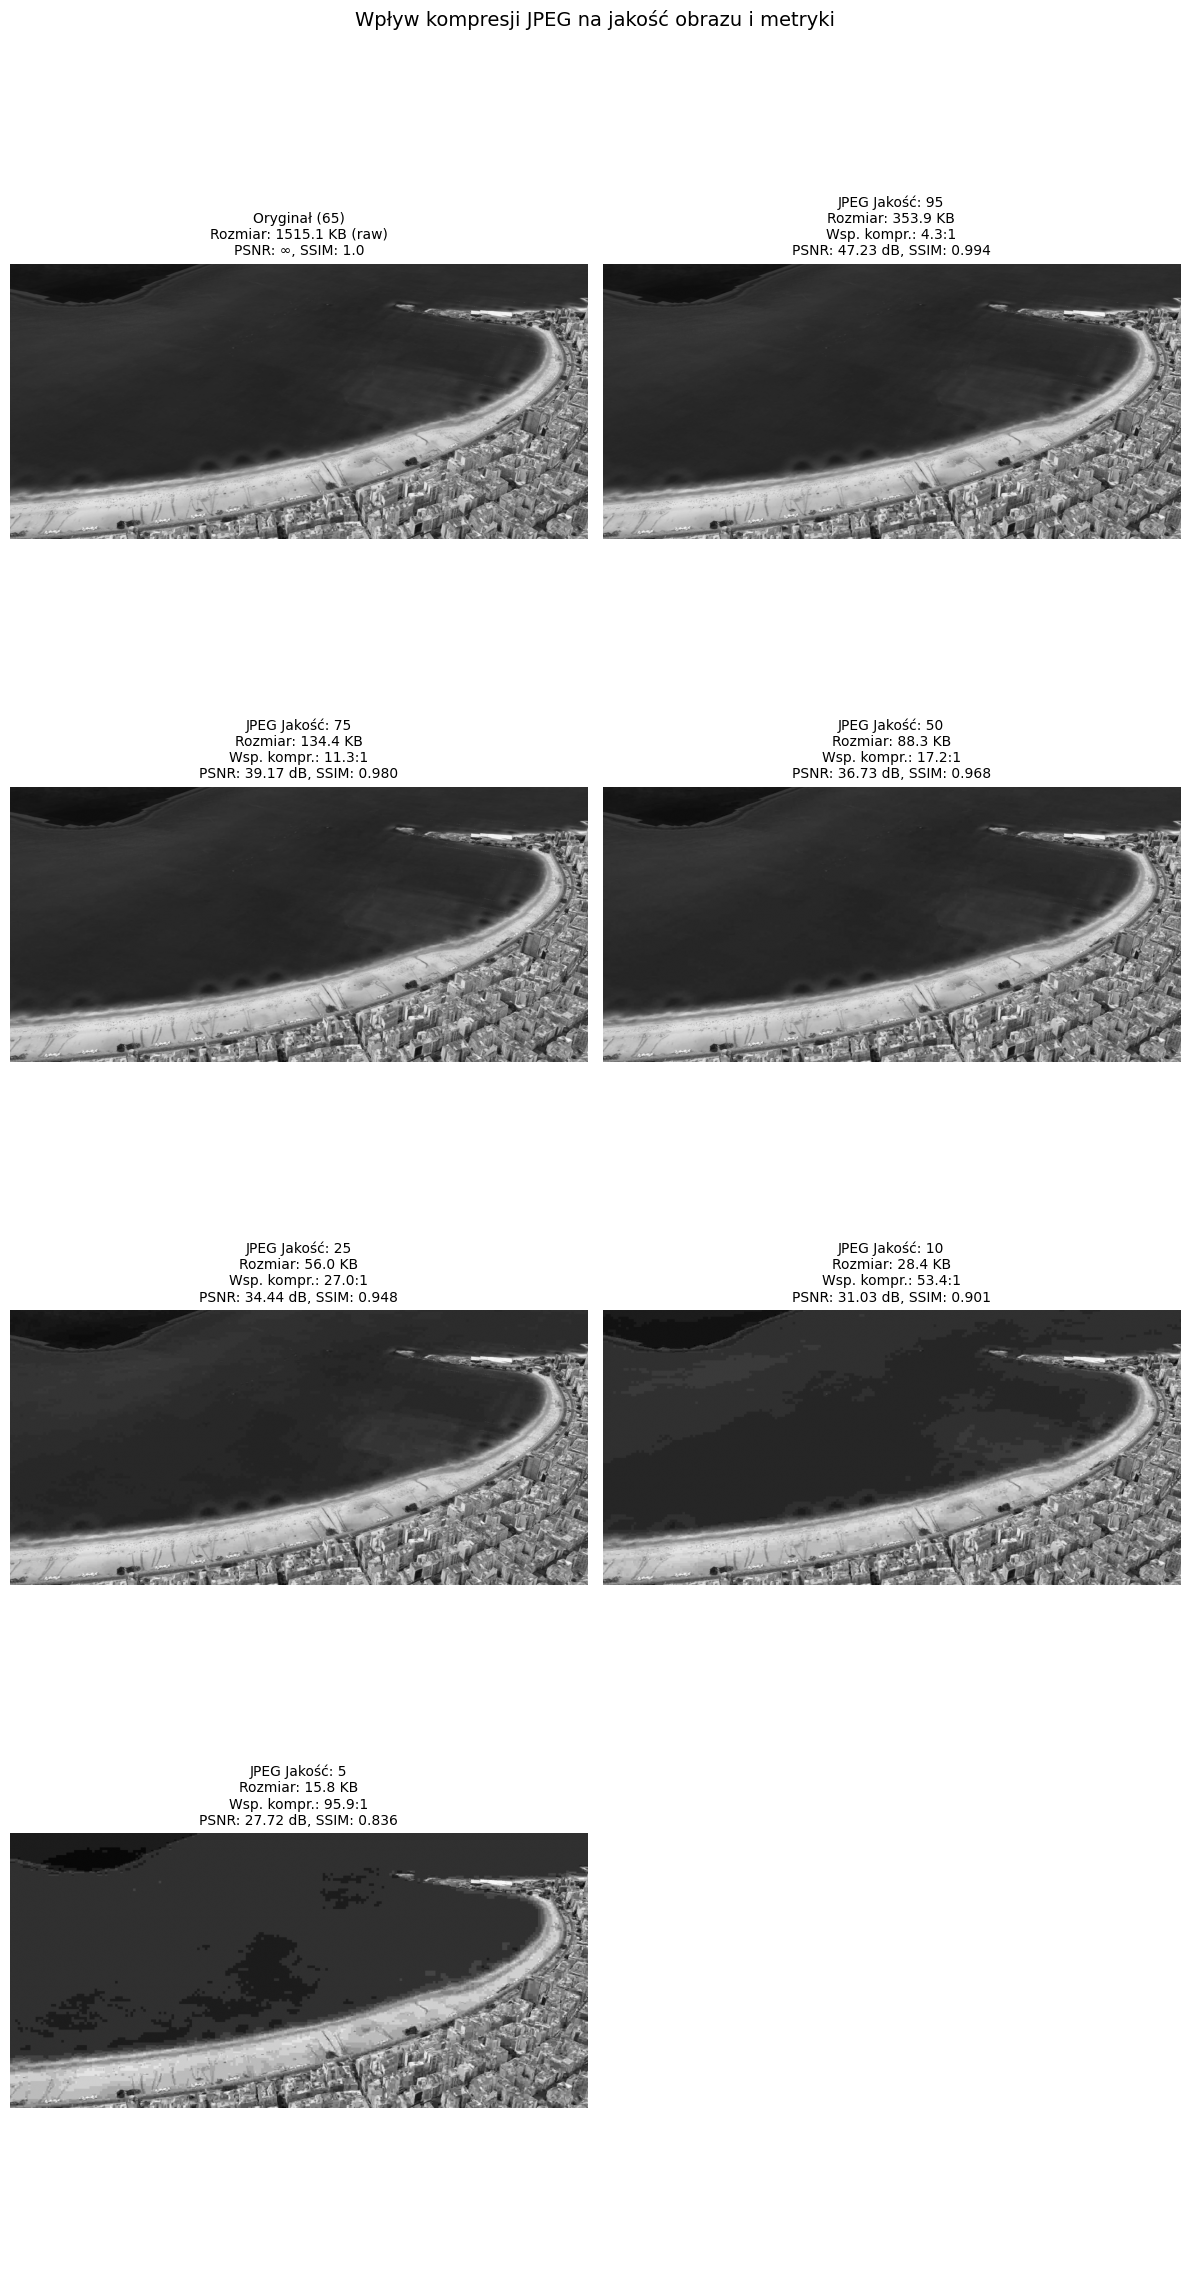

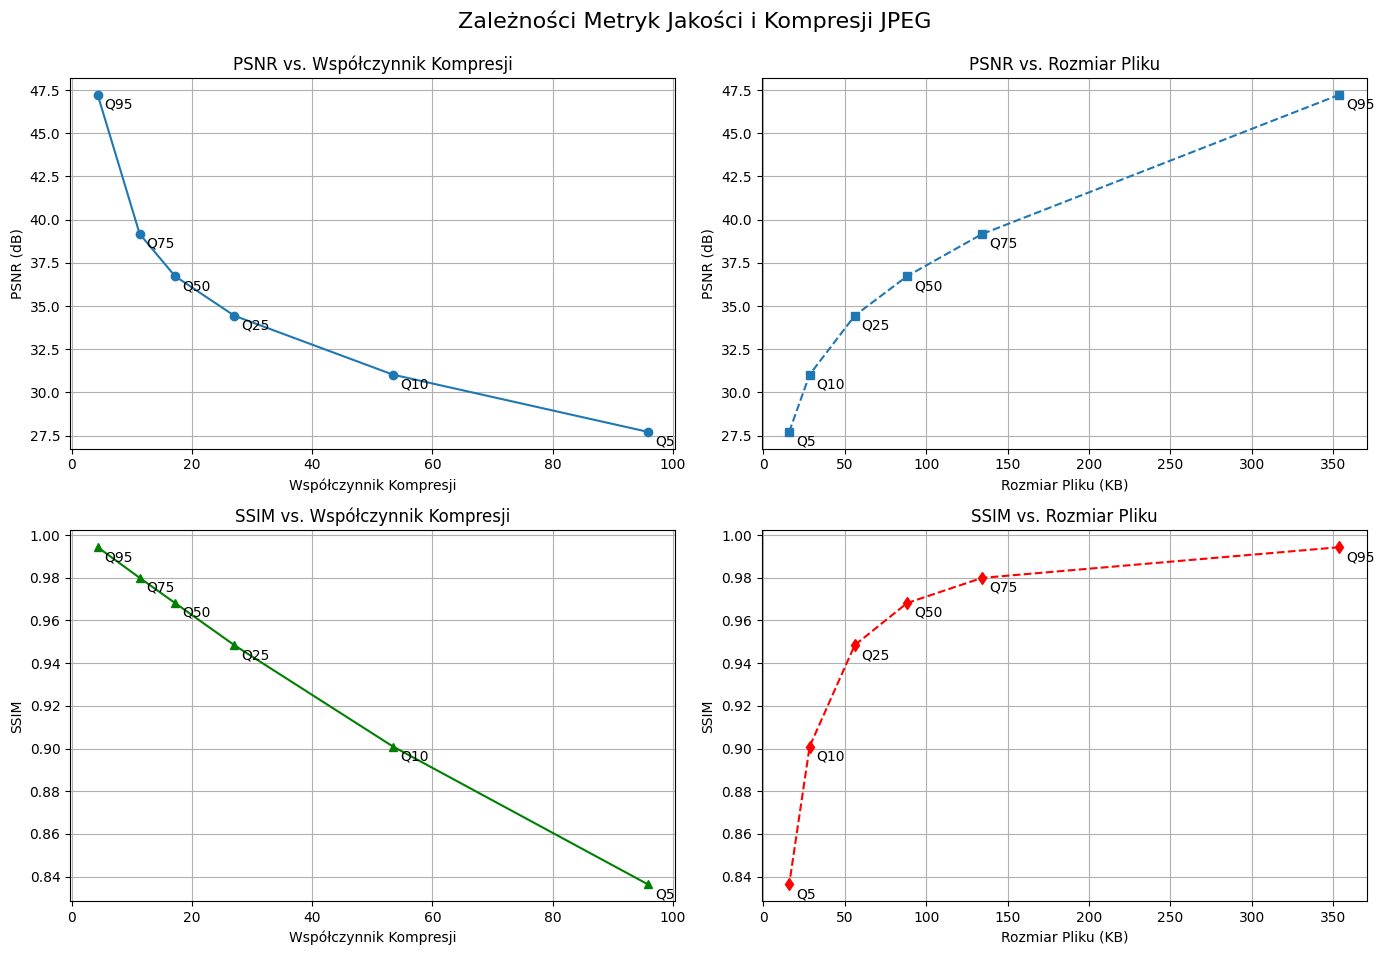

In [11]:
if 'original_image' in globals() and original_image is not None and \
   'compressed_results' in globals() and compressed_results:

    original_size_bytes = original_image.nbytes
    original_size_kb = original_size_bytes / 1024.0

    # --- Przygotowanie danych do wyświetlenia (tylko obrazy i ich metryki) ---
    display_items = []

    # Oryginalny obraz
    display_items.append({
        "image_to_show": original_image, # uint8
        "title_lines": [
            f"Oryginał ({image_filename.split('.')[0] if 'image_filename' in globals() else 'Obraz'})",
            f"Rozmiar: {original_size_kb:.1f} KB (raw)",
            "PSNR: ∞, SSIM: 1.0"
        ]
    })

    # Skompresowane obrazy
    for result in compressed_results:
        compression_ratio = original_size_kb / result["size_kb"] if result["size_kb"] > 0 else float('inf')
        display_items.append({
            "image_to_show": result["image"], # uint8
            "title_lines": [
                f"JPEG Jakość: {result['quality']}",
                f"Rozmiar: {result['size_kb']:.1f} KB",
                f"Wsp. kompr.: {compression_ratio:.1f}:1",
                f"PSNR: {result['psnr']:.2f} dB, SSIM: {result['ssim']:.3f}"
            ]
        })
    
    num_display_items = len(display_items)
    ncols_vis = 2 # Dwa obrazy w rzędzie
    nrows_vis = math.ceil(num_display_items / ncols_vis)

    fig_vis_width_per_subplot = 6 
    fig_vis_height_per_row = 6 # Można dostosować wysokość
    
    fig_vis, axes_vis = plt.subplots(nrows_vis, ncols_vis, 
                                     figsize=(fig_vis_width_per_subplot * ncols_vis, fig_vis_height_per_row * nrows_vis),
                                     squeeze=False) # squeeze=False jest dobre dla ogólności

    axes_flat = axes_vis.flatten() # Spłaszczenie dla łatwiejszej iteracji

    for i, item_data in enumerate(display_items):
        ax = axes_flat[i]
        ax.imshow(item_data["image_to_show"], cmap='gray', vmin=0, vmax=255)
        ax.set_title("\n".join(item_data["title_lines"]), fontsize=10)
        ax.axis('off')

    # Ukryj nieużywane osie, jeśli liczba obrazów nie wypełnia idealnie siatki
    for j in range(num_display_items, nrows_vis * ncols_vis):
        axes_flat[j].axis('off') # Prostsze niż fig.delaxes

    fig_vis.tight_layout(rect=[0, 0.03, 1, 0.95]) # Dostosuj rect dla suptitle
    fig_vis.suptitle("Wpływ kompresji JPEG na jakość obrazu i metryki", fontsize=14, y=0.98) # Dostosuj y
    plt.show()

    # --- Wykresy PSNR/SSIM vs. Współczynnik Kompresji / Rozmiar Pliku (bez zmian) ---
    # Ten kod pozostaje taki sam jak w poprzedniej odpowiedzi, gdzie generował wykresy 2x2.
    # Upewnij się, że masz dane: qualities, psnr_values, ssim_values,
    # compression_ratios_all, file_sizes_all, compression_ratios_for_ssim,
    # file_sizes_for_ssim, qualities_for_ssim zdefiniowane przed tą sekcją.
    
    # (Poniżej jest kopia sekcji wykresów punktowych dla kompletności)
    qualities = [res['quality'] for res in compressed_results]
    psnr_values = [res['psnr'] for res in compressed_results]
    # Upewnij się, że ssim_values i odpowiednie listy dla osi X są poprawnie filtrowane, jeśli SSIM mogło nie zostać obliczone
    valid_indices_for_ssim = [idx for idx, res in enumerate(compressed_results) if 'ssim' in res and not np.isnan(res['ssim'])]
    ssim_values = [compressed_results[i]['ssim'] for i in valid_indices_for_ssim]
    
    compression_ratios_all = [(original_size_kb / res['size_kb']) if res['size_kb'] > 0 else float('inf') 
                              for res in compressed_results]
    file_sizes_all = [res['size_kb'] for res in compressed_results]

    compression_ratios_for_ssim = [compression_ratios_all[i] for i in valid_indices_for_ssim]
    file_sizes_for_ssim = [file_sizes_all[i] for i in valid_indices_for_ssim]
    qualities_for_ssim = [qualities[i] for i in valid_indices_for_ssim]

    if psnr_values: # Tylko jeśli mamy jakiekolwiek wyniki
        fig_scatter, ax_scatter = plt.subplots(2, 2, figsize=(14, 10))

        # PSNR vs CR
        ax_scatter[0, 0].plot(compression_ratios_all, psnr_values, marker='o', linestyle='-')
        ax_scatter[0, 0].set_xlabel("Współczynnik Kompresji")
        ax_scatter[0, 0].set_ylabel("PSNR (dB)")
        ax_scatter[0, 0].set_title("PSNR vs. Współczynnik Kompresji")
        ax_scatter[0, 0].grid(True)
        for i, quality_val in enumerate(qualities): # Zmieniono 'quality' na 'quality_val' by uniknąć konfliktu z pętlą zewnętrzną
            ax_scatter[0, 0].annotate(f"Q{quality_val}", (compression_ratios_all[i], psnr_values[i]), textcoords="offset points", xytext=(5,-10), ha='left')

        # PSNR vs Rozmiar
        ax_scatter[0, 1].plot(file_sizes_all, psnr_values, marker='s', linestyle='--')
        ax_scatter[0, 1].set_xlabel("Rozmiar Pliku (KB)")
        ax_scatter[0, 1].set_ylabel("PSNR (dB)")
        ax_scatter[0, 1].set_title("PSNR vs. Rozmiar Pliku")
        ax_scatter[0, 1].grid(True)
        for i, quality_val in enumerate(qualities):
            ax_scatter[0, 1].annotate(f"Q{quality_val}", (file_sizes_all[i], psnr_values[i]), textcoords="offset points", xytext=(5,-10), ha='left')

        # SSIM vs CR
        if ssim_values:
            ax_scatter[1, 0].plot(compression_ratios_for_ssim, ssim_values, marker='^', linestyle='-', color='green')
            ax_scatter[1, 0].set_xlabel("Współczynnik Kompresji")
            ax_scatter[1, 0].set_ylabel("SSIM")
            ax_scatter[1, 0].set_title("SSIM vs. Współczynnik Kompresji")
            ax_scatter[1, 0].grid(True)
            for i, quality_val in enumerate(qualities_for_ssim):
                ax_scatter[1, 0].annotate(f"Q{quality_val}", (compression_ratios_for_ssim[i], ssim_values[i]), textcoords="offset points", xytext=(5,-10), ha='left')
        else:
            ax_scatter[1,0].text(0.5, 0.5, "Brak danych SSIM", ha='center', va='center', transform=ax_scatter[1,0].transAxes)
            ax_scatter[1,0].axis('off')


        # SSIM vs Rozmiar
        if ssim_values:
            ax_scatter[1, 1].plot(file_sizes_for_ssim, ssim_values, marker='d', linestyle='--', color='red')
            ax_scatter[1, 1].set_xlabel("Rozmiar Pliku (KB)")
            ax_scatter[1, 1].set_ylabel("SSIM")
            ax_scatter[1, 1].set_title("SSIM vs. Rozmiar Pliku")
            ax_scatter[1, 1].grid(True)
            for i, quality_val in enumerate(qualities_for_ssim):
                ax_scatter[1, 1].annotate(f"Q{quality_val}", (file_sizes_for_ssim[i], ssim_values[i]), textcoords="offset points", xytext=(5,-10), ha='left')
        else:
            ax_scatter[1,1].text(0.5, 0.5, "Brak danych SSIM", ha='center', va='center', transform=ax_scatter[1,1].transAxes)
            ax_scatter[1,1].axis('off')

        fig_scatter.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig_scatter.suptitle("Zależności Metryk Jakości i Kompresji JPEG", fontsize=16, y=0.98)
        plt.show()
    else:
        print("Brak wyników kompresji do wygenerowania wykresów punktowych.")


elif 'original_image' in globals() and original_image is not None and \
    ('compressed_results' not in globals() or not compressed_results):
     print("\nOryginalny obraz został wczytany, ale nie ma wyników kompresji do wyświetlenia.")
else:
    print("\nNie można wyświetlić wyników, ponieważ oryginalny obraz nie został wczytany.")